## HuBERT features + regularized logistic regression

We extract HuBERT features for one participant and fit an L^2-regularized
regression classifier on those features to predict label. The regularization
strength is determined by a hyperparameter search. Using the optimal hyperparameter,
we compute unweighted f_1 score using both ordinary cross validation, and
hold-one-session-out validation. We also compute performance on the test set.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from tqdm.notebook import tqdm

from helpers import get_hubert_features, unweighted_f1

In [2]:
# Get HuBERT features for one participant
hubert_features = get_hubert_features("P05")

  0%|          | 0/981 [00:00<?, ?it/s]

In [3]:
# There are 768 generated features, which is a lot
# relative to how many training data there are. So we
# will need regularization. Using sk-optimize to optimize
# strength of regularization parameter (this is overkill
# since there's just one parameter, but oh well)
X_tr, y_tr = hubert_features["X_tr"], hubert_features["y_tr"]
est = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10**6))
opt = BayesSearchCV(
    est,
    {
        "logisticregression__C": (5e-3, 1, "log-uniform"),
    },
    n_iter=20,
    cv=KFold(n_splits=10, shuffle=True, random_state=12345),
    scoring="f1_macro",
)
opt.fit(X_tr, y_tr)
print(opt.best_params_)
print("Best f1 score:", np.round(opt.best_score_, 4))
C = opt.best_params_["logisticregression__C"]

OrderedDict([('logisticregression__C', 0.03361316666633539)])
Best f1 score: 0.5965


In [4]:
# Out-of-sample performance
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(C=C, max_iter=10**6),
)
oos_pred_prob = cross_val_predict(
    est,
    X_tr,
    y_tr,
    cv=KFold(
        n_splits=10,
        shuffle=True,
        random_state=1234,  # Using different seed to avoid over-fitting parameter
    ),
    method="predict_proba",
)
oos_pred = oos_pred_prob.argmax(1)
print("Out-of-sample f1 score:", unweighted_f1(y_tr, oos_pred))

Out-of-sample f1 score: 0.6158


In [5]:
# Out of session performance is substantially worse, suggesting the model might
# be picking up on background sounds
label_list = hubert_features["label_list"]
session_tr = hubert_features["session_tr"]
pred_prob = np.zeros((len(X_tr), len(label_list)))
pred_prob[:] = np.nan
for session in tqdm(np.unique(session_tr)):
    mask = session_tr == session
    est = make_pipeline(
        StandardScaler(),
        LogisticRegression(C=C, max_iter=10**6),
    )
    est.fit(X_tr[~mask], y_tr[~mask])
    pred = est.predict_proba(X_tr[mask])

    # In case any labels are missing from training data:
    pred_list = []
    for n in range(len(label_list)):
        pred_list.append(
            pred[:, est.steps[1][1].classes_.tolist().index(n)]
            if n in est.steps[1][1].classes_
            else np.zeros(mask.sum())
        )
    pred = np.vstack(pred_list).T
    pred_prob[mask] = pred
assert not np.isnan(pred_prob).any()
pred = pred_prob.argmax(1)
print("Out-of-session f1 score:", unweighted_f1(y_tr, pred))

  0%|          | 0/15 [00:00<?, ?it/s]

Out-of-session f1 score: 0.3933


In [6]:
est = make_pipeline(StandardScaler(), LogisticRegression(C=C, max_iter=10**6))
est.fit(X_tr, y_tr)
X_te, y_te = hubert_features["X_te"], hubert_features["y_te"]
pred = est.predict(X_te)
print("f1 score, all test:", unweighted_f1(y_te, pred))
session_te = hubert_features["session_te"]
small_session_mask = ~pd.Series(session_te).isin(session_tr)
print(
    "f1 score, holdout sessions:",
    unweighted_f1(y_te[small_session_mask], pred[small_session_mask]),
)
print(
    "f1 score, sessions shared with training data:",
    unweighted_f1(y_te[~small_session_mask], pred[~small_session_mask]),
)

f1 score, all test: 0.569
f1 score, holdout sessions: 0.3618
f1 score, sessions shared with training data: 0.6711


,selftalk,frustrated,delighted,dysregulated,happy
selftalk,45,7,21,6,3
frustrated,9,62,10,10,0
delighted,29,4,53,12,3
dysregulated,3,2,3,12,0
happy,1,0,2,2,9


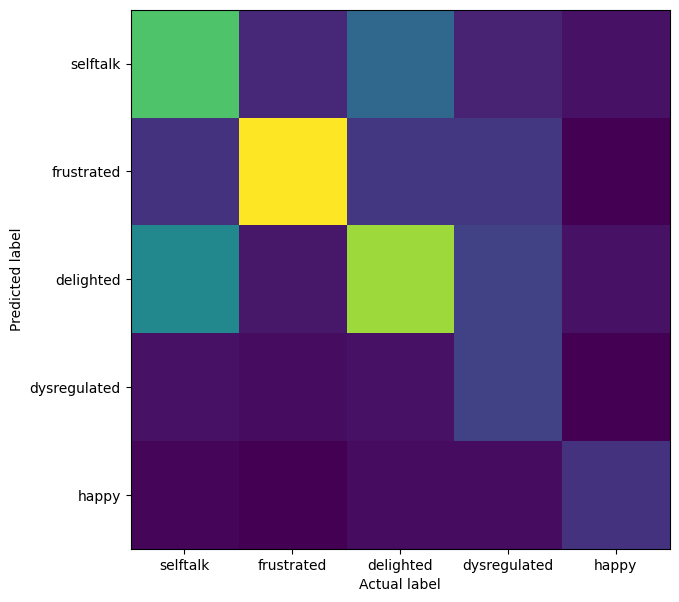

In [7]:
# Heatmap for test predictions
conf_mat = confusion_matrix(pred, y_te)
display(pd.DataFrame(conf_mat, label_list, label_list))
plt.figure(figsize=(7, 7))
plt.imshow(conf_mat, cmap="viridis", interpolation="nearest")
plt.xticks(range(len(label_list)), labels=label_list)
plt.yticks(range(len(label_list)), labels=label_list)
plt.ylabel("Predicted label")
plt.xlabel("Actual label")
plt.show()